## Setting up environment

In [66]:
!git clone https://github.com/Kangningthu/DeepDenoisingGuide

fatal: destination path 'DeepDenoisingGuide' already exists and is not an empty directory.


In [67]:
import os
import sys

file_root_path = '/content/DeepDenoisingGuide'
sys.path.append(file_root_path)
sys.path.append(file_root_path+'/electron-microscopy-denoising')
sys.path.append(file_root_path + '/electron-microscopy-denoising/models_microscopy')

from PIL import Image

import numpy as np
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

import cv2
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import glob
import pickle

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import argparse
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
from torch.distributions import Poisson
import matplotlib.patches as patches
from PIL import Image
import data
import models
import utils

import models_microscopy

In [68]:
device = torch.device('cpu')

In [69]:
def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i,:,:,:], Img[i,:,:,:], data_range=data_range)
    return (PSNR/Img.shape[0])

In [70]:
def simulate_Poisson_noise(data, noise_std = 0.1, max_noise = 5e-1, noise_scale=2):
    source = data
    scaled_source = source * noise_scale
    # Generate Poisson noise sample based on the scaled source
    noise_sample = Poisson(scaled_source).sample()
    # Scale back the generated noise
    noise_sample = (noise_sample - scaled_source) / noise_scale
    noise = noise_sample
    return noise

In [71]:
def tensor_to_image(torch_image, low=0.0, high = 1.0, clamp = True):
    if clamp:
        torch_image = torch.clamp(torch_image, low, high);
    return torch_image[0,0].cpu().data.numpy()

In [72]:
def apply_denoising_cnn_and_visualize_result(source, net, noise_sample=None, noise_scale=2.0, figsize=(20, 20)):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey='row', figsize=figsize)

    axes[0].imshow(tensor_to_image(source), cmap='gray')
    axes[0].axis('off')

    if noise_sample is None:
        noisy  = source + simulate_Poisson_noise(source, noise_scale = noise_scale)

    axes[1].imshow(tensor_to_image(noisy), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(str(batch_PSNR(noisy, source, 1.0)))

    denoised = net(noisy)

    axes[2].imshow(tensor_to_image(denoised), cmap='gray')
    axes[2].axis('off')
    axes[2].set_title(str(batch_PSNR(torch.clamp(denoised, 0.0, 1.0), source, 1.0)))

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [73]:
# Load example image
path = file_root_path + '/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
example_image = np.array(Image.open(path))
image_tensor = torch.tensor(example_image).unsqueeze(0).unsqueeze(0)
subindices_1_1 = 140
subindices_1_2 = 396
subindices_2_1 = 130
subindices_2_2 =386

In [74]:
# Load supervised model

path_aux = file_root_path + '/electron-microscopy-denoising/checkpoints/unet-128-small.pt'
state_dict = torch.load(path_aux, map_location=lambda s,l: default_restore_location(s,"cpu"))
args = argparse.Namespace(**{**vars(state_dict["args"])})
supervised_model = models_microscopy.build_model(args).to(device)
supervised_model.load_state_dict(state_dict["model"][0])

<ipython-input-74-fb41cab22259>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_aux, map_location=lambda s,l: default_restore_location(s,"cpu")

<All keys matched successfully>

In [75]:
# Load unsupervised model

unsupervised_model_path = file_root_path + '/pretrain_models/Microscopy//microscopy_noise2noise2.pth'
unsupervised_model = models_microscopy.build_model(args).to(device)
mode_statdict = torch.load( unsupervised_model_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))
unsupervised_model.load_state_dict(mode_statdict)

<ipython-input-75-c999911e741d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode_statdict = torch.load( unsupervised_model_path, map_location=lambda s,


<All keys matched successfully>

#### Supervised

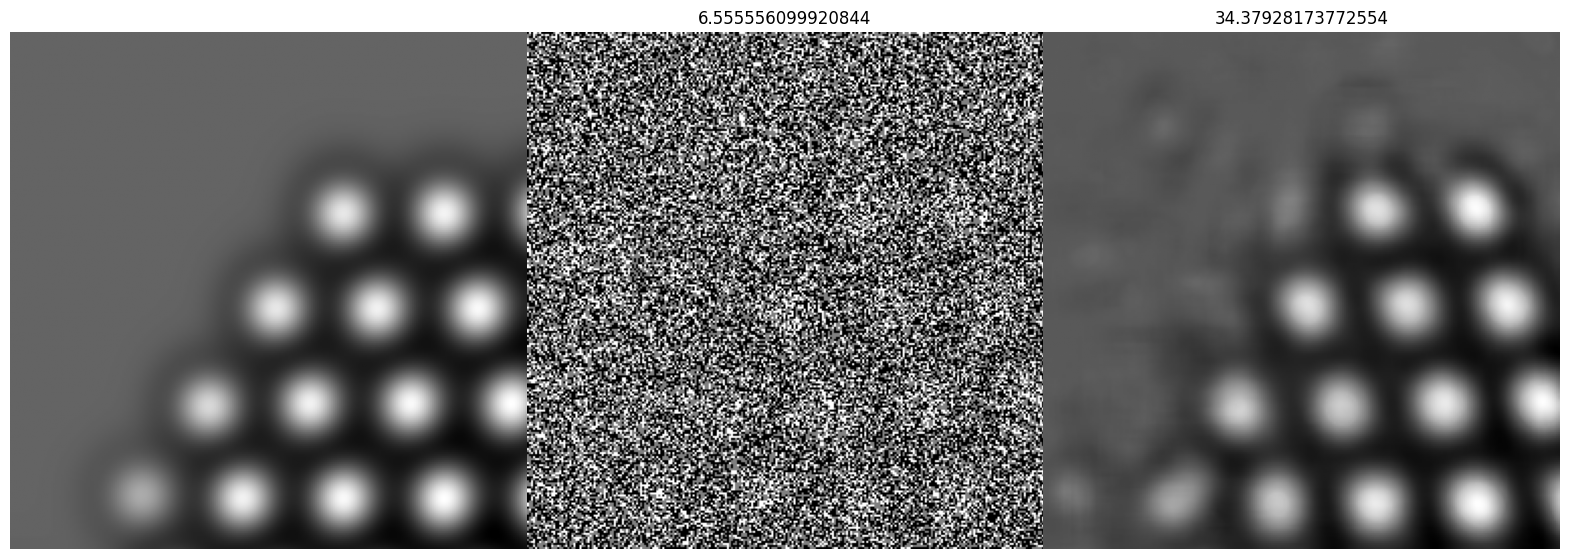

In [76]:
apply_denoising_cnn_and_visualize_result(image_tensor[:,:,subindices_1_1:subindices_1_2,subindices_2_1:subindices_2_2].to(device), supervised_model, figsize=(20, 10),noise_scale=2.0)

#### Unsupervised (noise2noise)

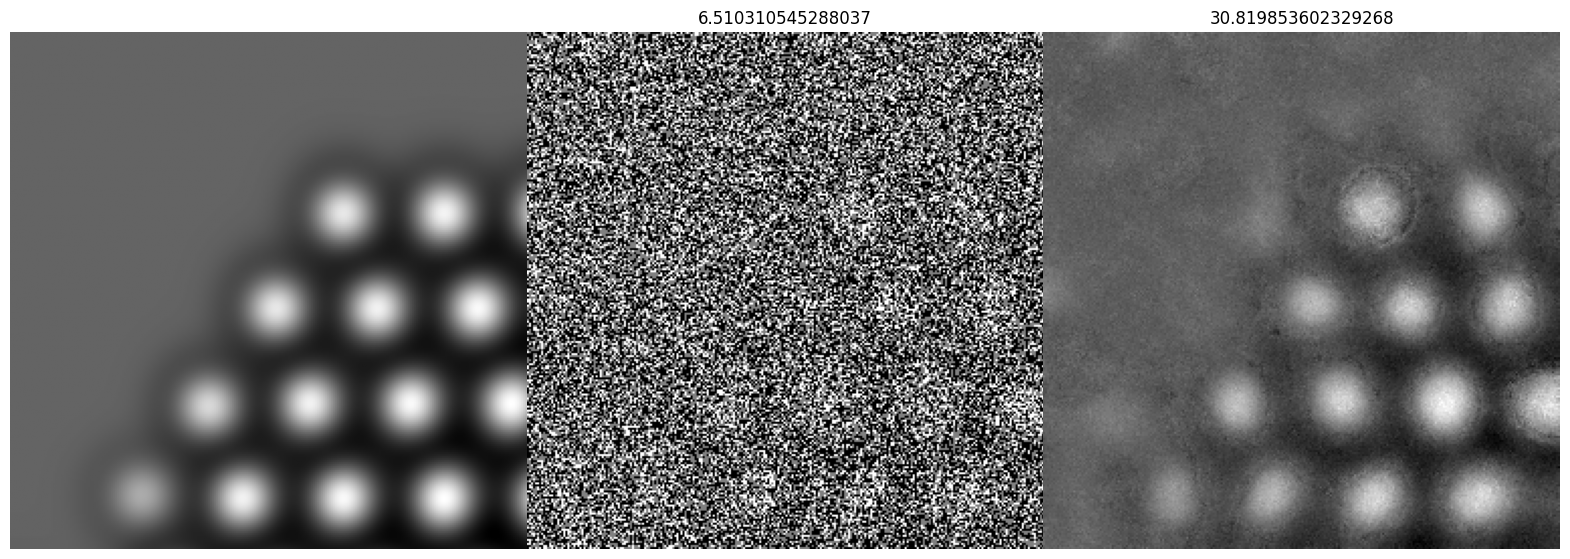

In [77]:
apply_denoising_cnn_and_visualize_result(image_tensor[:,:,subindices_1_1:subindices_1_2,subindices_2_1:subindices_2_2].to(device), unsupervised_model, figsize=(20, 10),noise_scale=2)

## Linear shift-invariant denoising

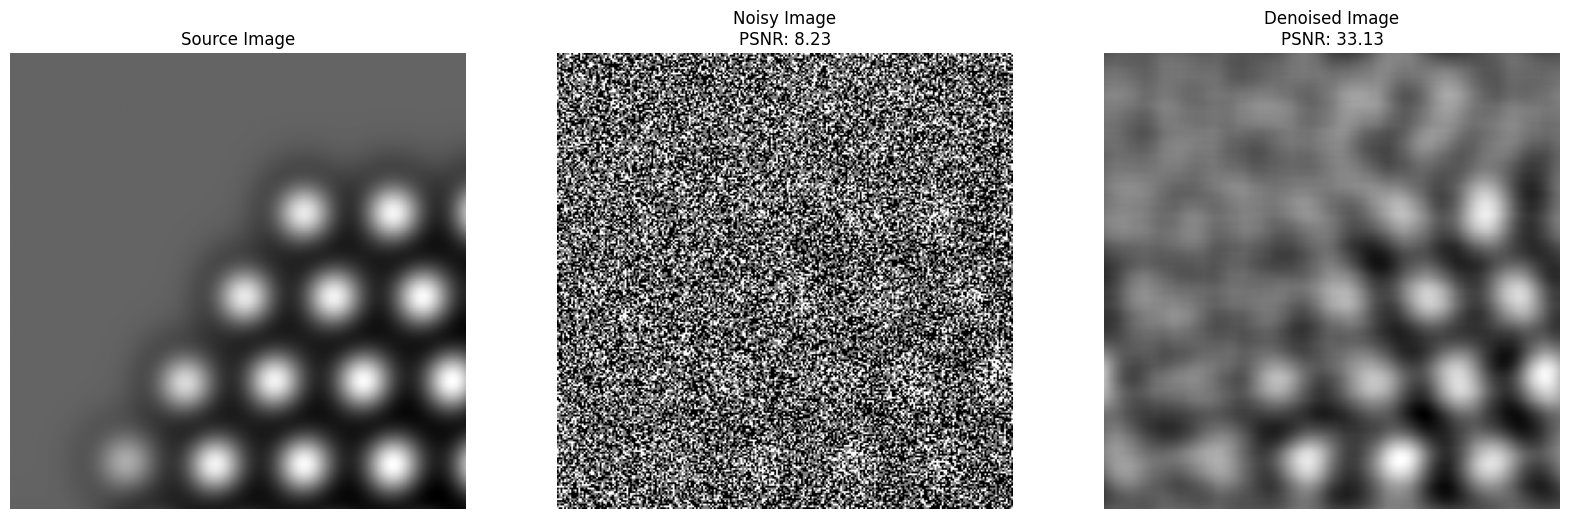

In [78]:
LSI_filter = np.load(path_to_saved_models + '/wiener_star.npy')

image_tensor = torch.tensor(example_image).unsqueeze(0)
source = image_tensor[:,subindices_1_1:subindices_1_2,subindices_2_1:subindices_2_2].to(device)
noisy = source + simulate_Poisson_noise(source)
noisy = noisy.numpy()[0]
source = source.numpy()[0]

# FFT and IFFT operations
fft_sample=(256, 256)
source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
denoised_fft = noisy_fft * LSI_filter

source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

# PSNR calculations
psnr_noisy = compare_psnr(source_ifft, noisy_ifft, data_range=1.)
psnr_denoised = compare_psnr(source_ifft, denoised_ifft, data_range=1.)

# Visualization in subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
images = [source_ifft, noisy_ifft, denoised_ifft]  # Use denoised_ifft for last to simulate FFT visualization
titles = ['Source Image', 'Noisy Image\nPSNR: {:.2f}'.format(psnr_noisy), 'Denoised Image\nPSNR: {:.2f}'.format(psnr_denoised)]

for ax, img, title in zip(axs, images, titles):

    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')